In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!git config --global credential.helper store

In [3]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 16 # batch size for training and evaluation

In [4]:
dataset_root_path = "/data/ZHO/formats/ucf101_letters_only"

!find {dataset_root_path} | head -5

/data/ZHO/formats/ucf101_letters_only
/data/ZHO/formats/ucf101_letters_only/train
/data/ZHO/formats/ucf101_letters_only/train/haa
/data/ZHO/formats/ucf101_letters_only/train/haa/Original_haa.mp4
/data/ZHO/formats/ucf101_letters_only/train/haa/Ganzo_haa.mp4
find: ‘standard output’: Broken pipe
find: write error


In [5]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [6]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(video_count_train, video_count_val, video_count_test)
print(f"Total videos: {video_total}")

64 32 32
Total videos: 128


In [7]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/data/ZHO/formats/ucf101_letters_only/train/haa/Original_haa.mp4'),
 PosixPath('/data/ZHO/formats/ucf101_letters_only/train/haa/Ganzo_haa.mp4'),
 PosixPath('/data/ZHO/formats/ucf101_letters_only/train/khaa/Original_khaa.mp4'),
 PosixPath('/data/ZHO/formats/ucf101_letters_only/train/khaa/Ganzo_khaa.mp4'),
 PosixPath('/data/ZHO/formats/ucf101_letters_only/train/aeen/Original_aeen.mp4')]

In [8]:
class_labels = sorted({str(path).split("/")[6] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")
print(len(id2label))

Unique classes: ['aeen', 'alif', 'baa', 'daad', 'daal', 'faa', 'gaen', 'haa', 'haa_1', 'hamza_wow', 'hamza_yaa', 'jeem', 'kaaf', 'khaa', 'laa', 'laam', 'meem', 'noon', 'qaaf', 'raa', 'saa', 'saad', 'seen', 'sheen', 'taa', 'taa_1', 'tua', 'wow', 'yaa', 'zaai', 'zaal', 'zua'].
32


In [9]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [10]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


2022-11-29 11:35:50.606395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 11:35:50.708985: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 11:35:51.340451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local

In [11]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size
print(resize_to)
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

print(resize_to,clip_duration,num_frames_to_sample)
# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize((resize_to, resize_to)),
                    #RandomCrop(resize_to),
                    #RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

224
224 2.1333333333333333 16


In [12]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(64, 32, 32)

In [13]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [14]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name Ganzo_wow.mp4
video_index 54
clip_index 0
aug_index 0
label 27
Video label: wow


In [15]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

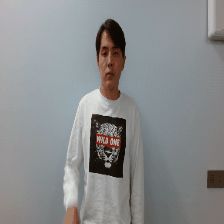

In [16]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [17]:
#del model
#del trainer
#torch.cuda.empty_cache()

In [17]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.1.attention.attention.v_bias', 'decoder.head.bias', 'encoder_to_decoder.weight', 'decoder.decoder_layers.3.attention.output.dense.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.2.layernorm_after.weight', 'decoder.decoder_layers.3.attention.attention.q_bias', 'decoder.decoder_layers.1.layernorm_before.weight', 'decoder.decoder_layers.3.attention.output.dense.weight', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.1.attention.output.dense.weight', 'decoder.decoder_layers.1.layernorm_after.weight', 'decoder.decoder_layers.3.layernorm_after.bias', 'decoder.decoder_layers.2.attention.attention.q_bias', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.1.laye

In [18]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-arsl_zho_alphabets"
num_epochs = 100
batch_size =3


In [19]:
num_epochs=100

In [20]:

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub= False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [21]:
import evaluate

metric = evaluate.load("accuracy")

In [22]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [25]:
train_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6300
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 2100
  Number of trainable parameters = 86251808


Epoch,Training Loss,Validation Loss,Accuracy
0,3.525600,3.498730,0.037736
1,3.511100,3.483281,0.018868
2,3.601800,3.490967,0.037736
3,3.535500,3.489396,0.037736
4,3.652100,3.488244,0.037736
5,3.620300,3.472960,0.037736
6,3.571300,3.471734,0.037736
7,3.562900,3.477349,0.037736
8,3.539400,3.477865,0.018868
9,3.627800,3.471344,0.037736


***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 3
Saving model checkpoint to videomae-base-finetuned-arsl_zho_alphabets/checkpoint-22
Configuration saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-22/config.json
Model weights saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-22/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-22/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 3
Saving model checkpoint to videomae-base-finetuned-arsl_zho_alphabets/checkpoint-44
Configuration saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-44/config.json
Model weights saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-44/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-arsl_zho_alphabets/checkpoint-44/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 3
Saving model check

In [3]:
import torch

In [19]:
triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2,reduce=False)
anchor = torch.randn(100, 6, requires_grad=False)
positive = torch.randn(100, 6, requires_grad=False)
negative = torch.randn(100, 6, requires_grad=False)
output = triplet_loss(anchor, positive, negative)
#output.backward()

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [18]:
print(output.shape)

torch.Size([100])


In [8]:
print(output.grad)

None


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


In [9]:

from torchviz import make_dot

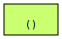

In [15]:
make_dot(output, params=dict(triplet_loss.named_parameters()))
